In [155]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/data/wadld/")
import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
from utils import (
    utils,
    draw_wad,
    wadreader,
    data_transformation
)
from utils.utils import duplicate_linedefs
import sklearn
import sklearn.mixture as mixture
import sklearn.cluster as cluster
import seaborn as sns
from utils.rendering import draw_traversable_space, draw_linedefs
from utils.wadreader import decode_wad
from utils.io_utils import get_wad_paths
from ml.feature_extraction import feature_mat

sns.reset_orig()  # get default matplotlib styles back

ddir = "/data/wadld/data/dataset/"
df_filename = "all_wads.pkl"
df = pd.read_pickle(os.path.join(ddir, df_filename))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [164]:
df.loc[(df.average_rating > 4.5)]

,special_type,zip_location,votes,average_rating,title,success,wad_file,dir_location,reviews,description,name
ftp://mirrors.syringanetworks.net/idgames/levels/doom/Ports/d-f/draftex.zip,Ports,dataset/zips/draftex_0.zip,44,5.25,Thy Flesh - Turned into a draft-excluder,True,[dataset/draftex_0/draftex.wad],dataset/draftex_0/,"[{'author': 'damned', 'score': 3.0, 'review': ...",Episode 4 replacement for the Ultimate Doom wh...,draftex
ftp://mirrors.syringanetworks.net/idgames/levels/doom/Ports/g-i/ginferno.zip,Ports,dataset/zips/ginferno_0.zip,1,5.00,Green Inferno,True,[dataset/ginferno_0/ginferno.wad],dataset/ginferno_0/,[],"Big inspiration from E4M1 ""Hell Beneath"". This...",ginferno
ftp://mirrors.syringanetworks.net/idgames/levels/doom/a-c/classic10b.zip,none,dataset/zips/classic10b_0.zip,3,5.00,Doom Classic 10b: Mercurius Pools without the ...,True,[dataset/classic10b_0/classic10b.wad],dataset/classic10b_0/,"[{'author': 'Anonymous', 'score': 5.0, 'review...",A level in the classic Doom style. Theme = Base,classic10b
ftp://mirrors.syringanetworks.net/idgames/levels/doom/d-f/dork.zip,none,dataset/zips/dork_0.zip,1,5.00,Dork,True,[dataset/dork_0/DORK.WAD],dataset/dork_0/,"[{'author': 'Mosshopper', 'score': 5.0, 'revie...",,dork
ftp://mirrors.syringanetworks.net/idgames/levels/doom/d-f/dzone100.zip,none,dataset/zips/dzone100_0.zip,9,5.25,Dead Zone v1.00,True,[dataset/dzone100_0/DEADZONE.WAD],dataset/dzone100_0/,"[{'author': 'Lightning Hunter', 'score': 5.0, ...",An epic level named after the Dragon Ball Z mo...,dzone100
ftp://mirrors.syringanetworks.net/idgames/levels/doom/deathmatch/a-c/colony_1.zip,deathmatch,dataset/zips/colony_1_0.zip,1,5.00,COLONY_1.WAD,True,[dataset/colony_1_0/COLONY_1.WAD],dataset/colony_1_0/,[],This is a DEATHMATCH 2.0 pwad. Please play thi...,colony_1
ftp://mirrors.syringanetworks.net/idgames/levels/doom/deathmatch/d-f/dandeth2.zip,deathmatch,dataset/zips/dandeth2_1.zip,1,5.00,Dan Deathmatch Level #2,True,[dataset/dandeth2_1/DANDETH2.WAD],dataset/dandeth2_1/,"[{'author': 'Anonymous', 'score': 5.0, 'review...",A indoor arena style DeathMatch level with a f...,dandeth2
ftp://mirrors.syringanetworks.net/idgames/levels/doom/deathmatch/d-f/deadshri.zip,deathmatch,dataset/zips/deadshri_0.zip,6,5.25,And the Dead Shall Rise,True,[dataset/deadshri_0/DEADSHRI.WAD],dataset/deadshri_0/,"[{'author': 'Doomkid', 'score': 5.0, 'review':...",A really kewl and really hard level. Lots of c...,deadshri
ftp://mirrors.syringanetworks.net/idgames/levels/doom/deathmatch/d-f/dmswrd.zip,deathmatch,dataset/zips/dmswrd_0.zip,1,5.00,Sword of Damocles,True,[dataset/dmswrd_0/SWORD.WAD],dataset/dmswrd_0/,[],"As in the ancient story of Damocles, member of...",dmswrd
ftp://mirrors.syringanetworks.net/idgames/levels/doom/deathmatch/j-l/jet.zip,deathmatch,dataset/zips/jet_0.zip,1,5.00,JET.WAD,True,[dataset/jet_0/JET.WAD],dataset/jet_0/,[],"Deathmatch playhouse. Lots of ""detail."" Many s...",jet


In [165]:
wad_dir = "nos4dead_0" # "refinery_0"  # "pagbspd3_0/"
filename = "nos4dead.wad"# "REFINERY.WAD"# "pagbspd3.wad"
wad_path = os.path.join(ddir, wad_dir, filename)
vertices, linedefs, sidedefs, sectors = decode_wad(wad_path)
new_linedefs = duplicate_linedefs(linedefs)
walls_only = [line for line in new_linedefs if line.impassable()]
new_fmat = feature_mat(vertices, new_linedefs, sidedefs, sectors)
walls_fmat = feature_mat(vertices, walls_only, sidedefs, sectors)
print("duplicated features: {}".format(new_fmat.shape))
print("impassable only features: {}".format(walls_fmat.shape))

num_sides=1235
duplicated features: (1685, 133)
impassable only features: (791, 133)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


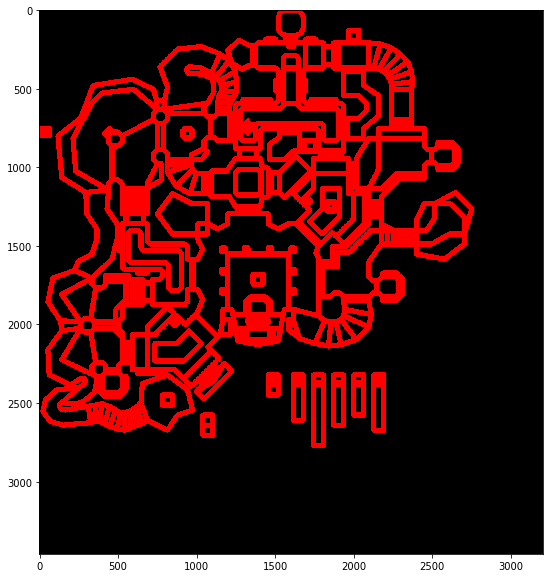

In [166]:
image = draw_linedefs(vertices, new_linedefs, color=(255, 0, 0))  # draw_traversable_space(vertices, new_linedefs, debug=True)
image_walls = cv2.resize(image, (int(image.shape[0]/8),int(image.shape[1]/8)))
plt.figure(figsize=(10, 10))
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


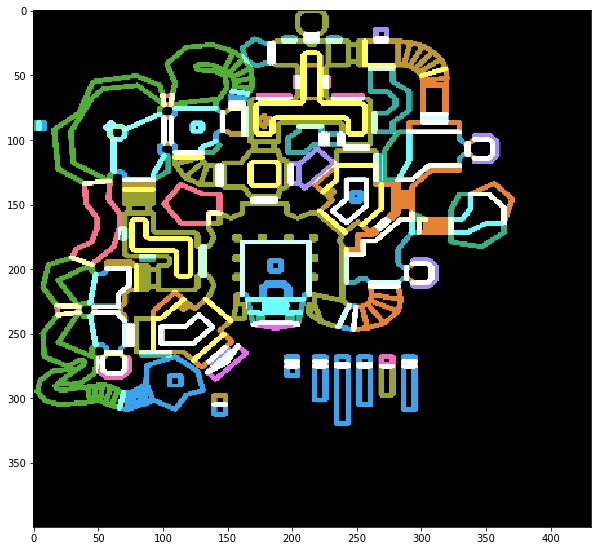

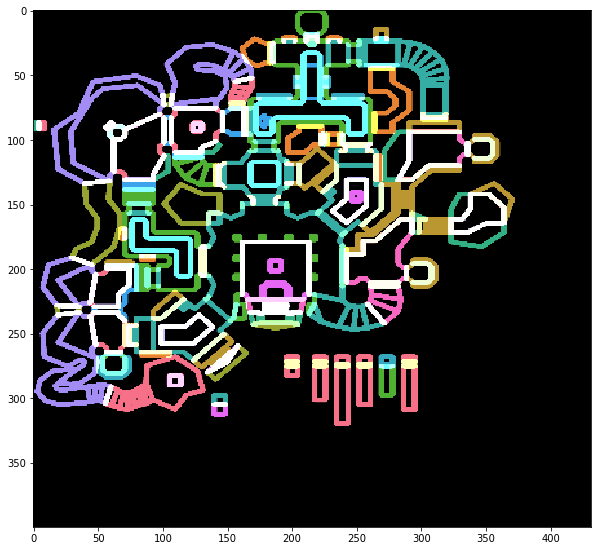

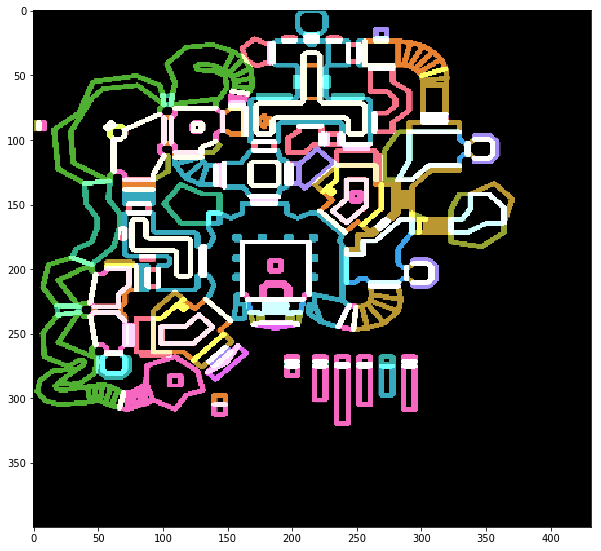

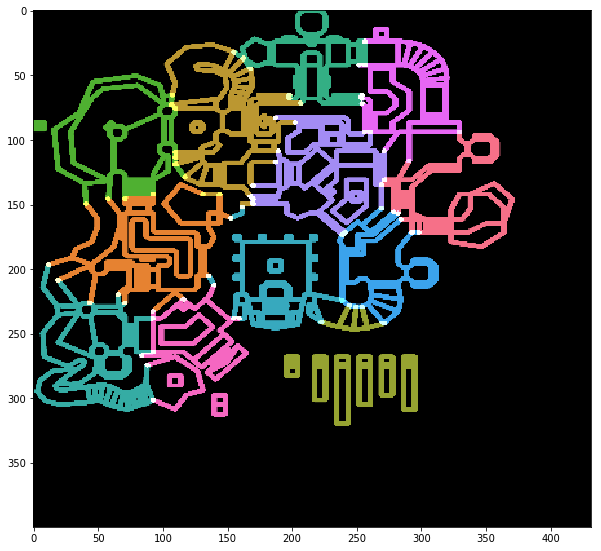

In [169]:
N = 12
X, estimator, labels = cluster_and_plot(
    vertices, 
    [line for line in new_linedefs],
    sidedefs, 
    sectors, 
    N, 
    figsize=((10, 10)),
    clustering_=mixture.GaussianMixture,
)

X, estimator, labels = cluster_and_plot(
    vertices, 
    [line for line in new_linedefs],
    sidedefs, 
    sectors, 
    N, 
    figsize=((10, 10)),
    clustering_=mixture.GaussianMixture,
)

X, estimator, labels = cluster_and_plot(
    vertices, 
    [line for line in new_linedefs], #  if line.impassable()], 
    sidedefs, 
    sectors, 
    N, 
    figsize=((10, 10)),
    feature_indices=[0, 1, 2, 3, -3, -2, -1],
)

X, estimator, labels = cluster_and_plot(
    vertices, 
    [line for line in new_linedefs], #  if line.impassable()], 
    sidedefs, 
    sectors, 
    N, 
    figsize=((10, 10)),
    feature_indices=[0, 1, 2, 3] # , -3, -2, -1],
)